FUERZA MAXIMA EN HIP THRUST TREN INFERIOR
MEDIANTE APRENDISAJE POR REFUERZO


In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

PASO I EL ENTORNO SIMULADOR (HIP THRUST)  
     ENTORNO DE SOBRECARGA PROGRESIVA SIMULANDO EL ENTRENAMIENTO DE HIP THRUST TREN INFERIOR, EL OBJETIVO ES AUMENTAR LA FUERZA BASE (F_max) DEL USUARIO A LARGO PLAZO.

In [4]:
class HipThrustTrenInferior:

    def __init__(self, initial_fmax=100.0, k_gain=0.005):

        # PARAMETRO DE ENTORNO
        self.k_gain = k_gain
        self.initial_fmax = initial_fmax
        self.F_max = initial_fmax

        # ESPACIOS DE ESTADO
        self.state_space = (4, 3, 3)
        self.observation_space_size = np.prod(self.state_space)

        # ESPACIO DE ACCION
        self.action_space_size = 5
        self.current_state = None

        self.reset()

    def reset(self):
        # REINICIA EL ESTADO INICIAL
        self.current_state = (0, 1, 0)
        self.F_max = self.initial_fmax
        return self._state_to_index(self.current_state)

    def _state_to_index(self, state):
        # CONVIERTE EL ESTADO EN UN INDICE UNICO
        s1, s2, s3 = state
        return s1 * 9 + s2 * 3 + s3

    def _get_real_params(self, state):
        # MAPEA EL ESTADO DISCRETO
        s1_weight_level, s2_rep_level, s3_fatigue_level = state

        # MAPEO DE PESO RELATIVO S1 A % DEL 1RM
        weight_percentages = [0.80, 0.85, 0.90, 0.95]
        target_weight = self.F_max * weight_percentages[s1_weight_level]

        # MAPEO DE REPETICIONES S2
        target_reps = [5, 10, 15][s2_rep_level]

        # MAPEO DE FATIGA S3 A UN FACTOR DE PENALIZACION DE LA FUERZA
        fatigue_factor = 1.0 - (s3_fatigue_level * 0.1)

        return target_weight, target_reps, fatigue_factor

    def step(self, action):

        # EL ENTORNO EJECUTA UNA ACCION Y DEVUELVE EL NUEVO ESTADO, LA RECOMPENSA Y EL EPISODIO TERMINO

        planned_weight, planned_reps, fatigue_factor = self._get_real_params(self.current_state)

        # CÁLCULO DE LA RECOMPENSA Y EL FALLO
        prob_failure = planned_weight / (self.F_max * fatigue_factor)
        stimulus = planned_weight * planned_reps

        reward = 0
        is_failure = prob_failure > 1.0 or random.random() < (prob_failure - 1.0)

        if is_failure:

            # PENALIDAD POR FALLO/SOBREENTRENAMIENTO
            reward = -5
            self.F_max -= (self.F_max * 0.001)
            next_fatigue = min(self.current_state[2] + 1, 2)

        else:
            # ENTRENAMIENTO EXITOSO
            max_possible_stimulus = self.F_max * 0.95 * 15

            if stimulus > (max_possible_stimulus * 0.70):
                # RECOMPENSA MÁXIMA POR PROGRESO
                reward = 10
                delta_fmax = self.k_gain * stimulus
                self.F_max += delta_fmax
                next_fatigue = min(self.current_state[2] + 1, 2)

            else:
                # RECOMPENSA MODERADA
                reward = 3
                next_fatigue = max(self.current_state[2] - 1, 0)

        # ACTUALIZACIÓN DE ESTADO (Transición)
        s1_weight_level, s2_rep_level, _ = self.current_state

        # MANTENER
        if action == 0:
            next_state = (s1_weight_level, s2_rep_level, next_fatigue)

        # SUBIR REPETICIONES
        elif action == 1:
            next_state = (s1_weight_level, min(s2_rep_level + 1, 2), next_fatigue)

        # SUBIR CARGA
        elif action == 2:
            next_state = (min(s1_weight_level + 1, 3), s2_rep_level, next_fatigue)

        # BAJAR CARGA
        elif action == 3:
            next_state = (max(s1_weight_level - 1, 0), s2_rep_level, next_fatigue)

        # SUBIR AMBOS REPETICION Y CARGA
        elif action == 4:
            next_state = (min(s1_weight_level + 1, 3), min(s2_rep_level + 1, 2), next_fatigue)

        else:
            raise ValueError("Acción no válida")

        self.current_state = next_state
        done = True

        return self._state_to_index(next_state), reward, done, {}

PASO II EL AGENTE DE Q_LEARNING  
  IMPLEMENTA EL ALGORITMO Q-LEARNING PARA ENTRENAR UN AGENTE

In [5]:
def q_learning_agent(env, num_episodes=10000):

    # HIPERPARAMETROS
    alpha = 0.1
    gamma = 0.9
    epsilon = 1.0
    epsilon_decay_rate = 0.0001
    min_epsilon = 0.01

    Q_table = defaultdict(lambda: np.zeros(env.action_space_size))
    fmax_history = []

    print(f"Comenzando el entrenamiento por {num_episodes} episodios (días de entrenamiento)...")

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            # ELEGIR ACCION: EPSILON-GREEDY
            if random.random() < epsilon:
                action = random.randrange(env.action_space_size)
            else:
                action = np.argmax(Q_table[state])

            next_state, reward, done, _ = env.step(action)

            # ACTUALIZAR LA Q-TABLE ECUACION DE BELLMAN
            old_value = Q_table[state][action]
            next_max = np.max(Q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            Q_table[state][action] = new_value

            state = next_state

        epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)
        fmax_history.append(env.F_max)

        if (episode + 1) % 1000 == 0:
            print(f"Episodio: {episode + 1}/{num_episodes}. F_max actual: {env.F_max:.2f} kg.")

    print("Entrenamiento finalizado.")
    return Q_table, fmax_history, env.F_max

PASO III EJECUCION, ANALISIS Y VISUALIZACION DETALLADA  
ANALISA LA Q-TABLE Y MUESTRA LA MEJOR ACCION PARA CADA ESTADO,  
 EJECUTA UNA SIMULACION CON LA POLITICA FINAL APRENDIDA.

Comenzando el entrenamiento por 10000 episodios (días de entrenamiento)...
Episodio: 1000/10000. F_max actual: 100.00 kg.
Episodio: 2000/10000. F_max actual: 100.00 kg.
Episodio: 3000/10000. F_max actual: 100.00 kg.
Episodio: 4000/10000. F_max actual: 100.00 kg.
Episodio: 5000/10000. F_max actual: 100.00 kg.
Episodio: 6000/10000. F_max actual: 100.00 kg.
Episodio: 7000/10000. F_max actual: 100.00 kg.
Episodio: 8000/10000. F_max actual: 100.00 kg.
Episodio: 9000/10000. F_max actual: 100.00 kg.
Episodio: 10000/10000. F_max actual: 100.00 kg.
Entrenamiento finalizado.
--------------------------------------------------
| FUERZA INICIAL (1RM): 100.00 kg
| FUERZA FINAL (1RM):   100.00 kg
| GANANCIA TOTAL:      0.00 kg
--------------------------------------------------
Política Óptima del Agente (Mejor Acción a Tomar):
| Peso: 80% / Reps: 10 / Fatiga: Baja -> Mejor Acción: **Mantener**
| Peso: 80% / Reps: 15 / Fatiga: Baja -> Mejor Acción: **Mantener**
| Peso: 85% / Reps: 10 / Fatiga: Baja ->

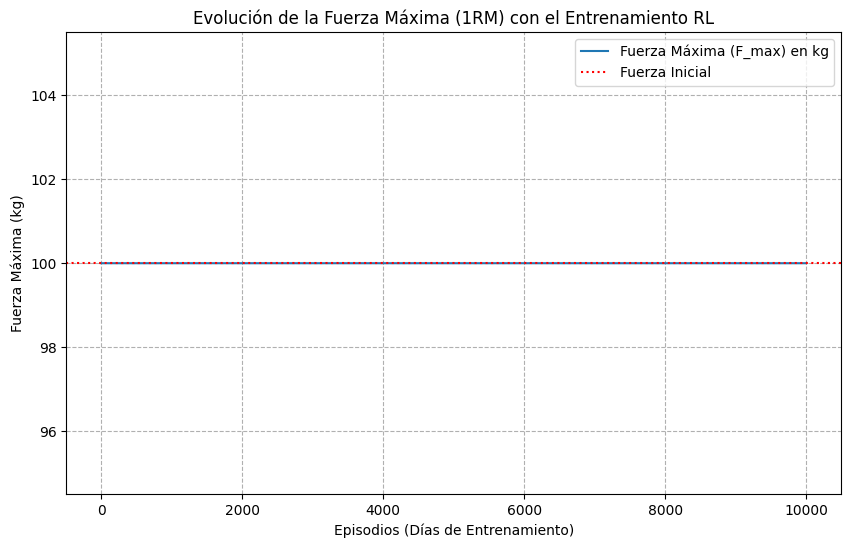

In [6]:
# INICIALIZAR
hip_thrust = HipThrustTrenInferior(initial_fmax=100.0)

# ENTRENAR
Q_table_final, fmax_historia, fmax_final = q_learning_agent(hip_thrust, num_episodes=10000)

print("-" * 50)
print(f"| FUERZA INICIAL (1RM): {hip_thrust.initial_fmax:.2f} kg")
print(f"| FUERZA FINAL (1RM):   {fmax_final:.2f} kg")
print(f"| GANANCIA TOTAL:      {fmax_final - hip_thrust.initial_fmax:.2f} kg")
print("-" * 50)

# MAPEOS PARA UNA MEJOR LECTURA DE SALIDAS
rep_map = {0: '5', 1: '10', 2: '15'}
fatigue_map = {0: 'Baja', 1: 'Media', 2: 'Alta'}
action_map = {0: 'Mantener', 1: 'Subir Reps', 2: 'Subir Carga', 3: 'Bajar Carga', 4: 'Subir Ambos'}
weight_map = {0: '80%', 1: '85%', 2: '90%', 3: '95%'}

# FUNCIÓN PARA INTERPRETAR LA POLÍTICA ÓPTIMA

def print_optimal_policy(Q_table, env):

    print("Política Óptima del Agente (Mejor Acción a Tomar):")

    policy_output = []

    for s1 in range(4):
        for s2 in range(3):
            for s3 in range(3):
                state_tuple = (s1, s2, s3)
                state_index = env._state_to_index(state_tuple)

                if state_index in Q_table:
                    best_action_index = np.argmax(Q_table[state_index])

                    policy_output.append(
                        f"| Peso: {weight_map[s1]} / Reps: {rep_map[s2]} / Fatiga: {fatigue_map[s3]} "
                        f"-> Mejor Acción: **{action_map[best_action_index]}**"
                    )

    for line in sorted(policy_output):
        print(line)

print_optimal_policy(Q_table_final, hip_thrust)

# FUNCIÓN DE BITÁCORA DE SESIONES

def run_simulation(env, Q_table, days=20):

    env.reset()

    print("\n" + "="*80)
    print("|ENTRENAMIENTO DE TREN INFERIOR HIP THRUST (Días con Política Óptima) |")
    print("="*80)

    header = "| Día | Fatiga | 1RM Inicial | Acción Elegida | Peso Planificado | Repeticion Planificadas | Recompensa (R) | 1RM Final |"
    print(header)
    print("-" * 80)

    for day in range(1, days + 1):

        current_state_tuple = env.current_state
        state_index = env._state_to_index(current_state_tuple)

        # Elegir la mejor acción (Explotación pura)
        action_index = np.argmax(Q_table[state_index]) if state_index in Q_table else 0

        fmax_before = env.F_max
        planned_w, planned_r, _ = env._get_real_params(current_state_tuple)

        # Ejecutamos el step para obtener el nuevo estado y la recompensa
        _, reward, _, _ = env.step(action_index)

        # Imprimir la bitácora
        print(
            f"| {day:<3} | "
            f"{fatigue_map[current_state_tuple[2]]:<6} | "
            f"{fmax_before:<11.2f} | "
            f"{action_map[action_index]:<14} | "
            f"{planned_w:<16.2f} | "
            f"{planned_r:<17} | "
            f"{reward:<14} | "
            f"{env.F_max:<9.2f} |"
        )

    print("-" * 80)

# LLAMADA A LA FUNCIÓN DE BITÁCORA
run_simulation(hip_thrust, Q_table_final, days=30)

# GRÁFICO DE PROGRESO DE LA FUERZA

plt.figure(figsize=(10, 6))
plt.plot(fmax_historia, label='Fuerza Máxima (F_max) en kg')
plt.title('Evolución de la Fuerza Máxima (1RM) con el Entrenamiento RL')
plt.xlabel('Episodios (Días de Entrenamiento)')
plt.ylabel('Fuerza Máxima (kg)')
plt.grid(True, linestyle='--')
plt.axhline(hip_thrust.initial_fmax, color='r', linestyle=':', label='Fuerza Inicial')
plt.legend()
plt.show()